In [166]:
import spacy

import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import json

from spacy.language import Language
from typing import Dict, List, Set, Tuple
from collections import defaultdict, namedtuple
import copy
from statistics import mean 
import io
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.protobuf.json_format import MessageToJson, Parse
from google.protobuf import json_format

import os
import sys
sys.path.append("../../")
from models.dish_segmenter import Dish
from models.bounding_box import FeatureType, Point, BoundingBox, DSU
from models.word_unit import WordUnit
from utils.cv_preprocess import *
from utils.file_utils import *
from utils.nlp_preprocess import *
from IPython.display import display


In [167]:
from sentence_transformers import SentenceTransformer, util

# Initialize the model, using a pre-trained transformer. This only needs to be done once.
model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_semantic_correlation(text1, text2, penalization_factor=0):
    """
    Calculate semantic correlation between two pieces of text.

    Args:
    text1 (str): First text to be compared.
    text2 (str): Second text to be compared.

    Returns:
    float: A semantic correlation score between 0 and 1, where 1 means very high similarity.
    """
    if text1.strip() == "" or text2.strip() == "":
        # Return a penalized score for cases with empty text
        return penalization_factor
    # Generate the embeddings for both texts
    embedding1 = model.encode(text1, convert_to_tensor=True)
    embedding2 = model.encode(text2, convert_to_tensor=True)
    
    # Compute cosine similarity between the embeddings
    cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
    
    # Return the cosine similarity score as a float
    return cosine_scores.item()

In [168]:
calculate_semantic_correlation("鸡", "vegetable")

0.15781274437904358

In [169]:
calculate_semantic_correlation("鸡", "")

0

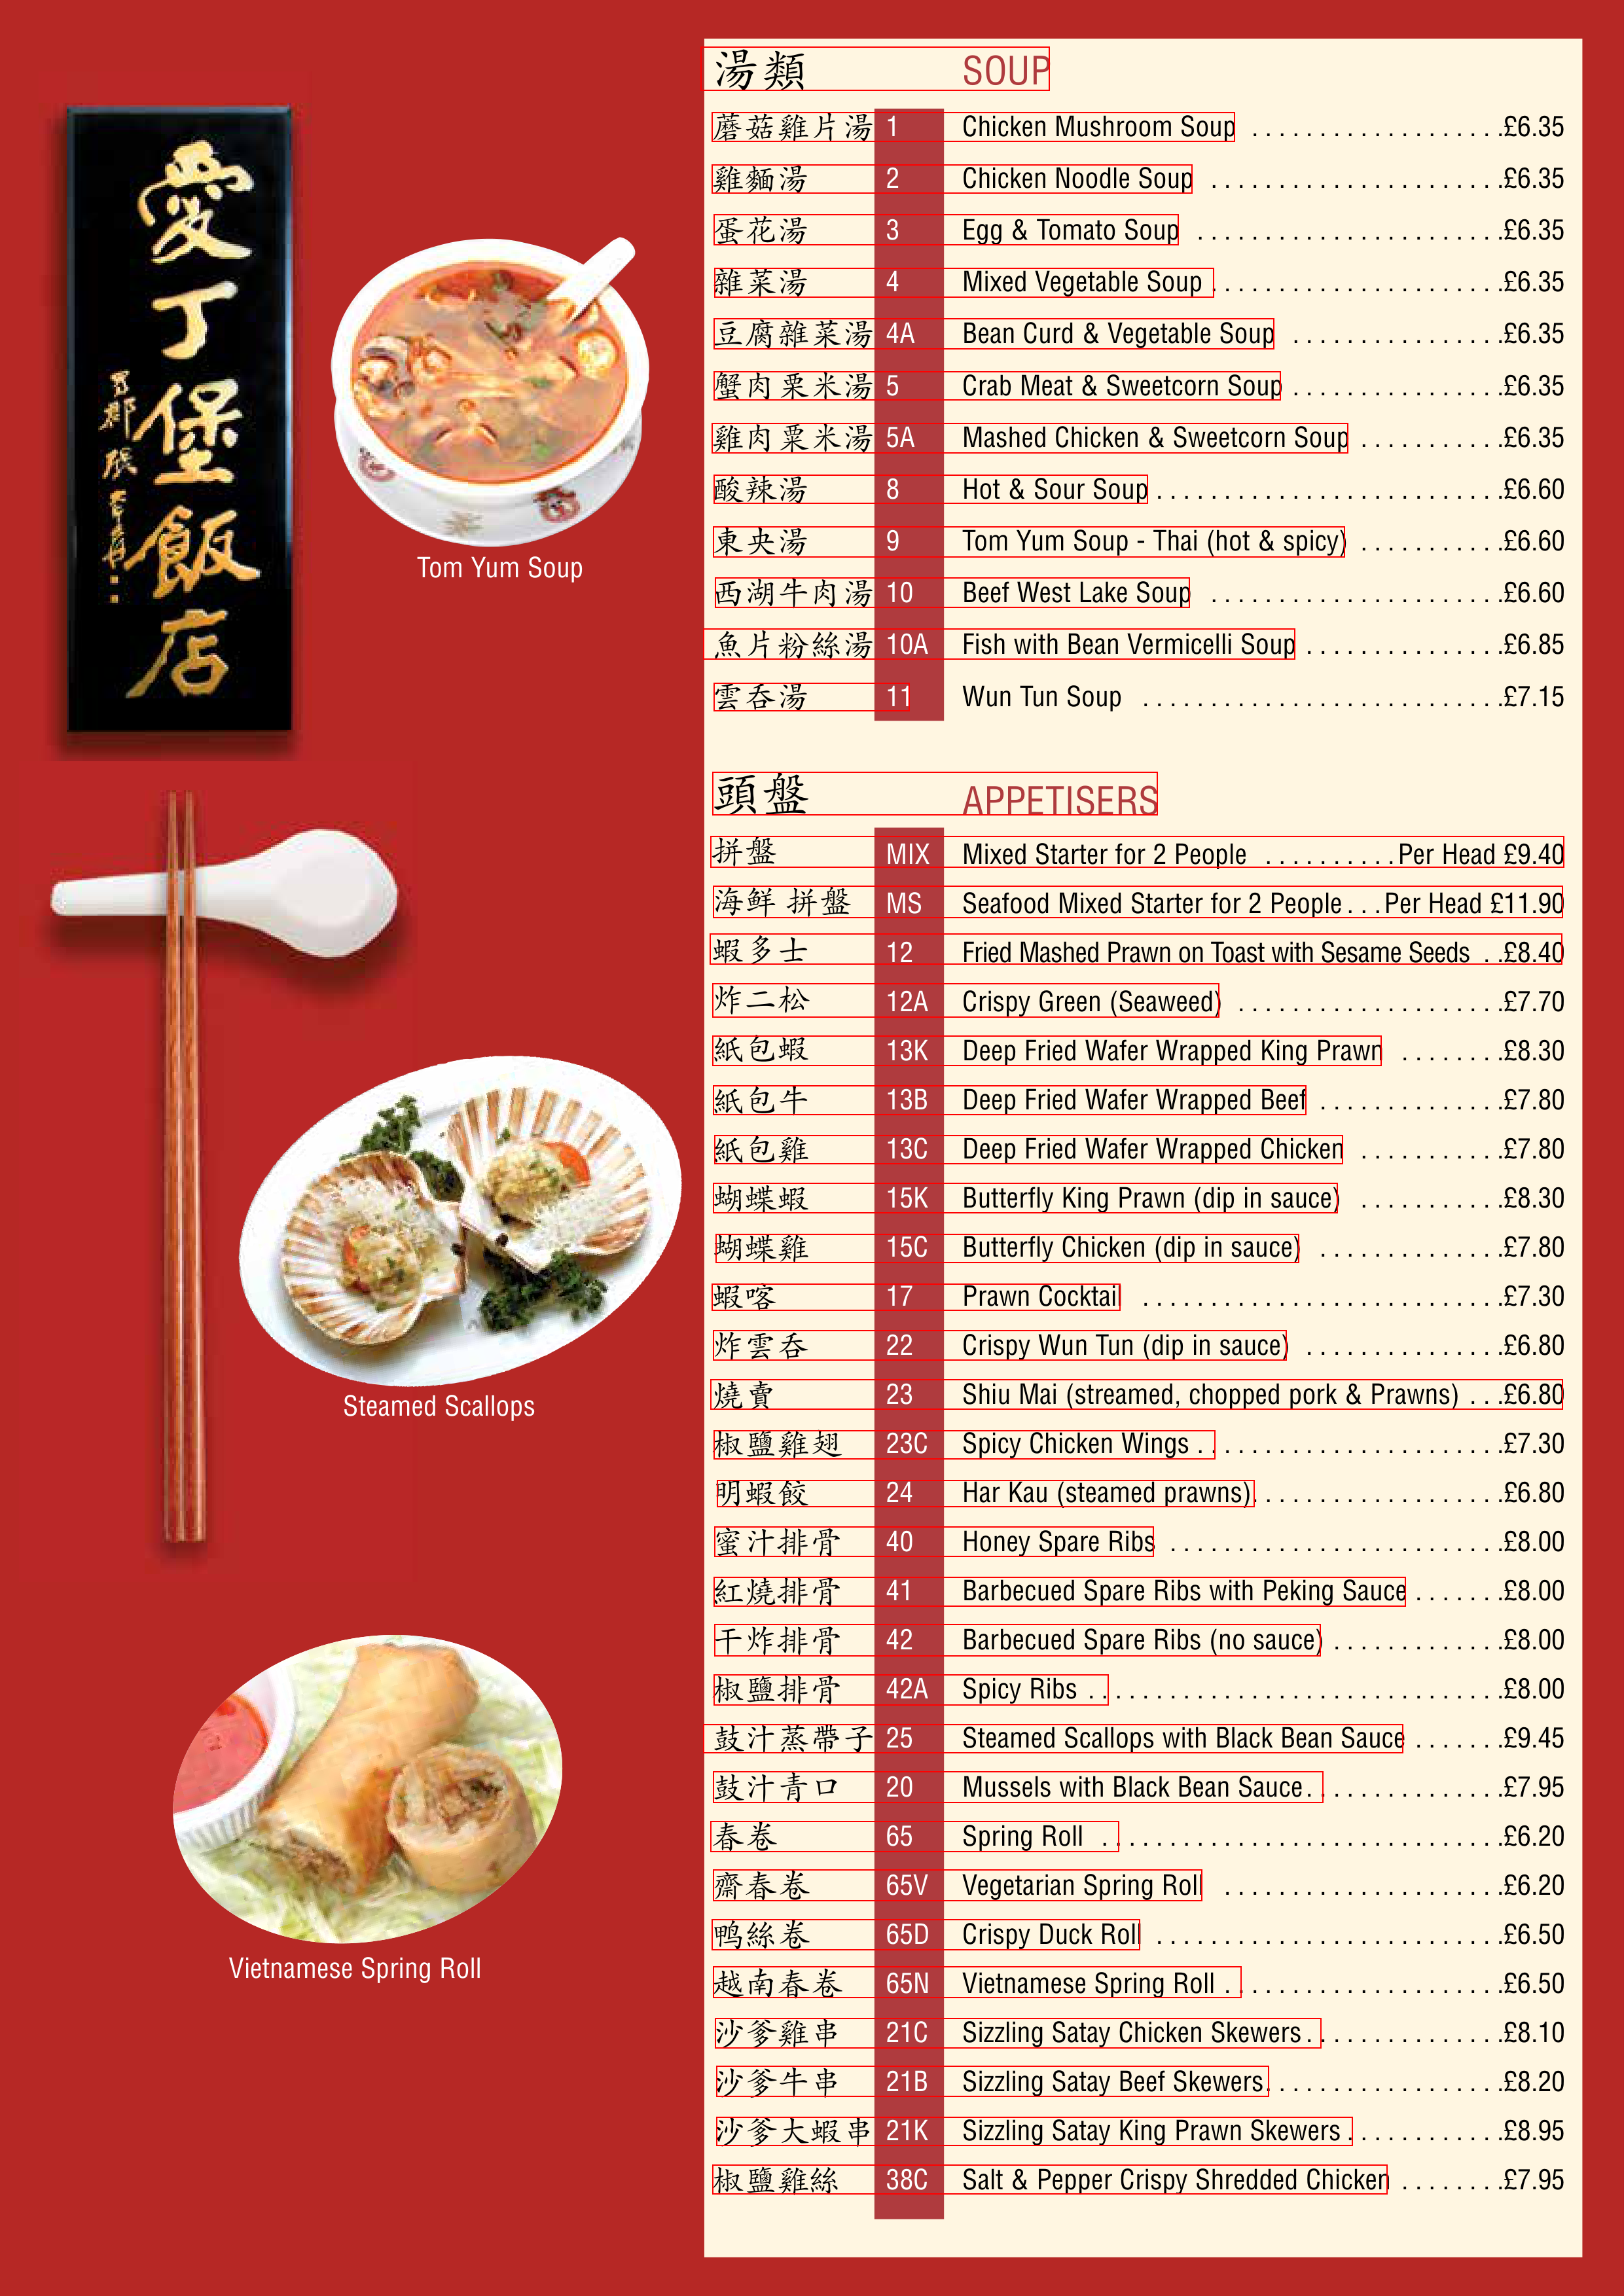

Chinese Name: ['湯類']
English Name: ['SOUP']
Chinese Description: []
English Description: []

Chinese Name: ['蘑菇', '雞', '片', '湯']
English Name: ['Chicken', 'Mushroom', 'Soup']
Chinese Description: []
English Description: []

Chinese Name: ['雞', '麵湯']
English Name: ['Chicken', 'Noodle', 'Soup']
Chinese Description: []
English Description: []

Chinese Name: ['蛋花湯']
English Name: ['Egg', 'and', 'Tomato', 'Soup']
Chinese Description: []
English Description: []

Chinese Name: ['雜', '菜湯']
English Name: ['Mixed', 'Vegetable', 'Soup']
Chinese Description: []
English Description: []

Chinese Name: ['豆腐', '雜', '菜湯']
English Name: ['4A']
Chinese Description: []
English Description: [['Bean', 'Curd', 'and', 'Vegetable', 'Soup']]

Chinese Name: ['蟹肉', '粟米', '湯']
English Name: ['Crab', 'Meat', 'and', 'Sweetcorn', 'Soup']
Chinese Description: []
English Description: []

Chinese Name: ['雞肉', '粟米', '湯']
English Name: ['5A']
Chinese Description: []
English Description: [['Mashed', 'Chicken', 'and', 'Swee

<Figure size 1000x1000 with 0 Axes>

In [170]:

def process_menu(filein):
    base_name = os.path.basename(filein)
    file_name_without_extension = os.path.splitext(base_name)[0]

    raw_ocr_directory = '../../dataset/menu_photo_ocr_raw/'
    raw_ocr_filename = file_name_without_extension + "_raw_annotation.json"
    raw_ocr_path = os.path.join(raw_ocr_directory, raw_ocr_filename)

    document = load_json(raw_ocr_path)
    image = Image.open(filein)
    
    

    bounds = process_bounds_in_words(document)
    

    price_bounds = extract_price_bounds(bounds)
    filtered_bounds, chinese_bbox, english_bbox = filter_and_classify_bounds(bounds)

    locator_bounds = [price_bounds, chinese_bbox]

    overlap_threshold_list = [0.3, 0.4, 0.5]

    container_width, container_height = image.size
    
    # loop through all possible extend directions
    extend_directions_pair = [[ExtendDirection.BOTTOM, ExtendDirection.LEFT], [ExtendDirection.BOTTOM, ExtendDirection.RIGHT], [ExtendDirection.TOP, ExtendDirection.LEFT], [ExtendDirection.TOP, ExtendDirection.RIGHT]]
    
    # find the extend direction that have the highest semantic correlation in chinese and english
    max_correlation = 0
    max_correlation_pair = None
    max_locator = None
    max_overlap = 0
    max_avg_correlation = 0

    max_grouped_list, max_grouped_box = None, None  
    for overlap_threshold in overlap_threshold_list:
        for locator_bound in locator_bounds:
            for extend_directions in extend_directions_pair:
                # print()
                # print("Processing", extend_directions)
                extended_boxes = extend_bounding_boxes(locator_bound, container_width, container_height, extend_directions=extend_directions)
                sorted_bounding_boxes = sorted(filtered_bounds, key=lambda bbox: (bbox.y_min, bbox.x_min))
                grouped_list, grouped_box = group_extended_boxes(extended_boxes, sorted_bounding_boxes, overlap_threshold=overlap_threshold)
                
                total_correlation = 0
                correlation_count = 0
                for string_list in grouped_list:
                    # flatten the list of strings by joining them
                    string_list = [" ".join(string) for string in string_list if string != ""]
                    
                    chinese_text, english_text = split_chinese_english(string_list)
                    chinese_text = "".join(chinese_text)
                    english_text = " ".join(english_text)
                    
                    correlation = calculate_semantic_correlation(chinese_text, english_text)
                    # print(chinese_text, english_text, correlation)
                    total_correlation += correlation
                    correlation_count += 1
                
                # Calculate average correlation if there are valid correlations
                if correlation_count > 0:
                    # avg_correlation = total_correlation / correlation_count
                    if total_correlation > max_avg_correlation:
                        max_avg_correlation = total_correlation
                        max_correlation_pair = extend_directions
                        max_grouped_list = grouped_list
                        max_grouped_box = grouped_box
                        max_locator = locator_bound
                        max_overlap = overlap_threshold
    

    draw_boxes_2_points(image, max_grouped_box, (255, 0, 0))
    plt.figure(figsize=(10, 10))
    display(image)
    
    dish_instance_list = []
    
    for string_list in max_grouped_list:
        # print(string_list)
        dish = segment_dish_text_list(string_list)
        print(dish)
        dish_instance_list.append(dish)

# Usage example
# filein = '../../dataset/menu_photo/8._New_Fortune_Cookie_0_page_5.png'
# filein = '../../dataset/menu_photo/menu-2023_page_1.png'
filein = '../../dataset/menu_photo/Rendezvous_sit-in_08-23_Draft_page_2.png'
# filein = '../../dataset/menu_photo/jimmy_express_4.png'
# filein = '../../dataset/menu_photo/barshu (4).png'


process_menu(filein)
